In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import mesh_tensorflow as mtf

import flowpm
import flowpm.mesh_ops as mpm
import flowpm.mtfpm as mtfpm
import flowpm.mesh_utils as mesh_utils
from astropy.cosmology import Planck15
from flowpm.tfpm import PerturbationGrowth
from flowpm import linear_field, lpt_init, nbody, cic_paint
from flowpm.utils import r2c3d, c2r3d

import sys, os
sys.path.append('../utils/')
import tools
import diagnostics as dg

import contextlib
import functools
import math, time
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline
import scipy.optimize as sopt


In [3]:

# def model(x):
#     return tf.reduce_sum(tf.square(x-tf.constant(2, dtype=tf.float32)))

# @tf.function
# def val_and_grad(x):
#     with tf.GradientTape() as tape:
#         tape.watch(x)
#         loss = model(x)
#     grad = tape.gradient(loss, x)
#     return loss, grad

# def func(x):
#     return [vv.numpy().astype(np.float64)  for vv in val_and_grad(tf.constant(x, dtype=tf.float32))]

# resdd= sopt.minimize(fun=func, x0=np.ones(5),
#                                       jac=True, method='L-BFGS-B')

# print("info:\n",resdd)

In [26]:
bs, nc = 200,64
nsteps = 5
a0, a, nsteps = 0.1, 1.0,  nsteps
stages = np.linspace(a0, a, nsteps, endpoint=True)

klin = np.loadtxt('../data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../data//Planck15_a1p00.txt').T[1]
ipklin = iuspline(klin, plin)
# Compute necessary Fourier kernels                                                                                                                           
kvec = tools.fftk((nc, nc, nc), boxsize=nc, symmetric=False)
kmesh = (sum(k**2 for k in kvec)**0.5).astype(np.float32)
priorwt = ipklin(kmesh)


<ipython-input-26-e36d2cc51310>:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmesh = (sum(k**2 for k in kvec)**0.5).astype(np.float32)


In [27]:
tf.keras.backend.clear_session()


In [28]:
ic = linear_field(nc, bs, ipklin).numpy()

@tf.function
def pm(linear):
    state = lpt_init(linear, a0=0.1, order=1)
    final_state = nbody(state,  stages, nc)
    tfinal_field = cic_paint(tf.zeros_like(linear), final_state[0])
    return tfinal_field

fin = pm(ic).numpy()

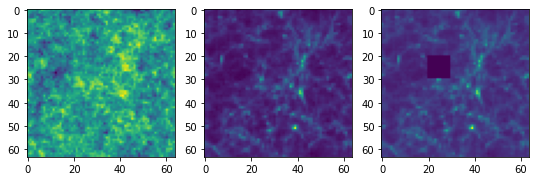

In [42]:
mask = np.ones(shape=(1, nc, nc)).astype(float32)

x1, x2 = 20, 30
y1, y2 = 20, 30
mask[0, x1:x2, y1:y2] = 0


fig, ax = plt.subplots(1, 3, figsize = (9, 4))
ax[0].imshow(ic[0].sum(axis=0))
ax[1].imshow(fin[0].sum(axis=0))
ax[2].imshow(fin[0].sum(axis=0)*mask[0])
plt.show()



In [30]:
def r2c2d(rfield, norm=None, dtype=tf.complex64, name="R2C3D"):
    with tf.name_scope(name):
        rfield = tf.convert_to_tensor(rfield, name="mesh")
        if norm is None: norm = tf.cast(tf.reduce_prod(rfield.get_shape()[1:]), dtype)
        else: norm = tf.cast(norm, dtype)
        cfield = tf.multiply(tf.signal.fft2d(tf.cast(rfield, dtype)), 1/norm, name=name)
        return cfield

def c2r2d(cfield, norm=None, dtype=tf.float32, name="C2R3D"):
    with tf.name_scope(name):
        cfield = tf.convert_to_tensor(cfield, name="mesh")
        if norm is None: norm = tf.cast(tf.reduce_prod(cfield.get_shape()[1:]), dtype)
        else: norm = tf.cast(norm, dtype)
        rfield = tf.multiply(tf.cast(tf.signal.ifft2d(cfield), dtype), norm, name=name)
        return rfield


kmesh2d = np.squeeze(sum(kvec[i]**2 for i in range(2))**0.5).astype(float32)

<ipython-input-30-6be2d480b859>:18: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmesh2d = np.squeeze(sum(kvec[i]**2 for i in range(2))**0.5).astype(float32)


In [43]:

anneal = True

@tf.function
def recon_prototype(linear, data, Rsm, mask):
    """                                                                                                                                                   
    """
    print(linear)
#     linear = tf.reshape(linear, data.shape)
    final_field = pm(linear)

#     residual = final_field - data 
    residual = (tf.reduce_sum(final_field, axis=1) - tf.reduce_sum(data, axis=1))*mask
    base = residual
    print(base)
    
    if anneal :
        print("\nAdd annealing section to graph\n")
        Rsmsq = tf.multiply(Rsm*bs/nc, Rsm*bs/nc)
        
#         smwts = tf.exp(tf.multiply(-kmesh**2, Rsmsq))
#         basek = r2c3d(base, norm=nc**3)
#         basek = tf.multiply(basek, tf.cast(smwts, tf.complex64))
#         base = c2r3d(basek, norm=nc**2)
        
        smwts = tf.exp(tf.multiply(-kmesh2d**2, Rsmsq))
        basek = r2c2d(base, norm=nc**3)
        basek = tf.multiply(basek, tf.cast(smwts, tf.complex64))
        base = c2r2d(basek, norm=nc**2)

        
    chisq = tf.multiply(base, base)
    chisq = tf.reduce_sum(chisq)
    chisq = tf.multiply(chisq, 1/nc**2, name='chisq')

    #Prior                                                                                                                                                
    lineark = r2c3d(linear, norm=nc**3)
    priormesh = tf.square(tf.cast(tf.abs(lineark), tf.float32))
    prior = tf.reduce_sum(tf.multiply(priormesh, 1/priorwt))
    prior = tf.multiply(prior, 1/nc**3, name='prior')
    #                                                                                                                                                     
    loss = chisq + prior

    return loss


@tf.function
def grad(x, y, Rsm, mask):
    with tf.GradientTape() as tape:
        tape.watch(x)
        loss = recon_prototype(x, y, Rsm, mask)
    grad = tape.gradient(loss, [x])
    return grad


# Create an optimizer for Adam.                                                                                                                           
opt = tf.keras.optimizers.Adam(learning_rate=0.1)



RRs = [2, 1, 0]
optimizer = 'adam'
niter = 100


#Loop it Reconstruction                                                                                                                                   
##Reconstruction                                                                                                                                          
x0 = np.random.normal(0, 1, nc**3).reshape(fin.shape).astype(np.float32)
linear = tf.Variable(name='linmesh', shape=(1, nc, nc, nc), dtype=tf.float32,
                         initial_value=x0, trainable=True)


for iR, RR in enumerate(RRs):

    for i in range(niter):
        grads = grad(linear, tf.constant(fin, dtype=tf.float32), 
                     tf.constant(RR, dtype=tf.float32), 
                    tf.constant(mask, dtype=tf.float32))
        opt.apply_gradients(zip(grads, [linear]))
    minic = linear.numpy().reshape(fin.shape)
    
    x0 = minic
    print('\nminimized\n')
    minfin = pm(tf.constant(minic, dtype=tf.float32)).numpy()

# x0 = np.random.normal(0, 1, nc**3).reshape(fin.shape).astype(np.float32)
# linear2 = tf.Variable(name='linmesh', shape=(1, nc, nc, nc), dtype=tf.float32,
#                          initial_value=x0, trainable=True)
# for iR, RR in enumerate(RRs):

#     for i in range(niter):
#         grads = grad(linear2, tf.constant(fin, dtype=tf.float32), 
#                      tf.constant(RR, dtype=tf.float32), 
#                     tf.constant(mask, dtype=tf.float32)*0 + 1)
#         opt.apply_gradients(zip(grads, [linear2]))
#     minic0 = linear2.numpy().reshape(fin.shape)
    
#     x0 = minic0
#     print('\nminimized\n')
#     minfin0 = pm(tf.constant(minic0, dtype=tf.float32)).numpy()

    



<tf.Variable 'linmesh:0' shape=(1, 64, 64, 64) dtype=float32>
Tensor("mul:0", shape=(1, 64, 64), dtype=float32)

Add annealing section to graph


minimized


minimized


minimized



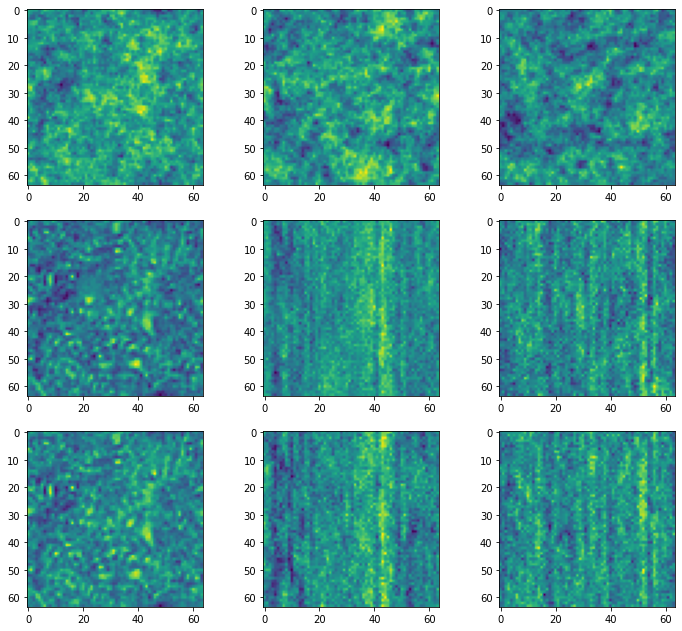

In [44]:
fig, ax = plt.subplots(3, 3, figsize = (12, 11))

for i in range(3): ax[0, i].imshow(ic[0].sum(axis=i))
for i in range(3): ax[1, i].imshow(minic[0].sum(axis=i))
for i in range(3): ax[2, i].imshow(minic0[0].sum(axis=i))

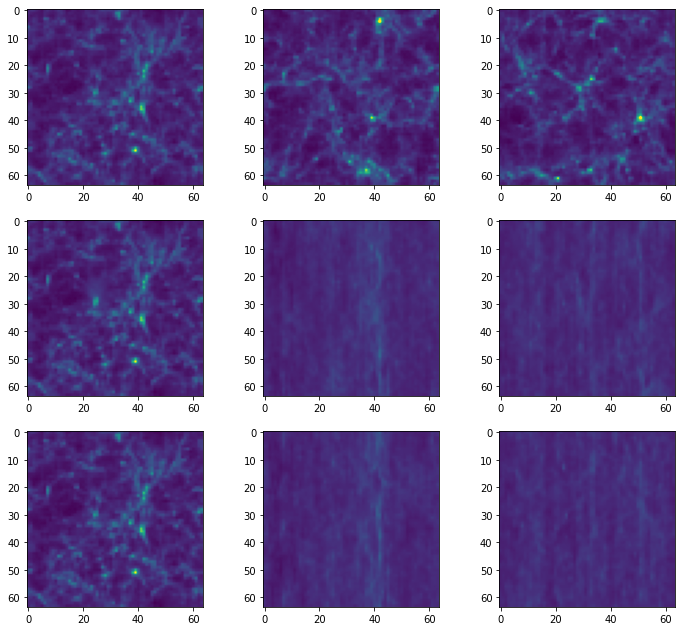

In [45]:
fig, ax = plt.subplots(3, 3, figsize = (12, 11))
vmin, vmax = fin[0].sum(axis=0).min(), fin[0].sum(axis=0).max()
for i in range(3): ax[0, i].imshow(fin[0].sum(axis=i), vmin=vmin, vmax=vmax)
for i in range(3): ax[1, i].imshow(minfin[0].sum(axis=i), vmin=vmin, vmax=vmax)
for i in range(3): ax[2, i].imshow(minfin0[0].sum(axis=i), vmin=vmin, vmax=vmax)

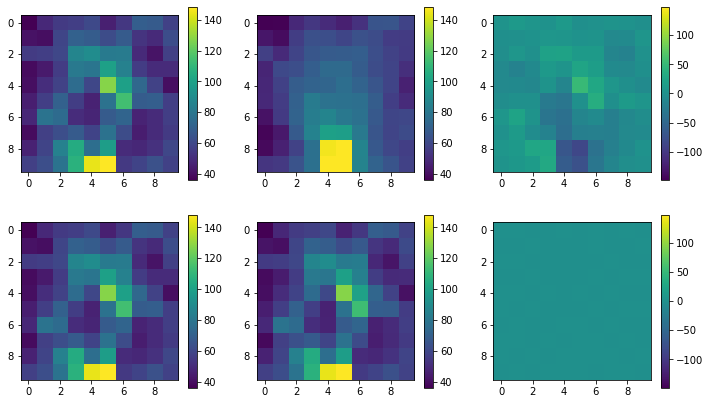

In [48]:
fig, ax = plt.subplots(2, 3, figsize = (12, 7))
vmin, vmax = fin[0].sum(axis=0)[x1:x2, y1:y2].min(), fin[0].sum(axis=0)[x1:x2, y1:y2].max()
im = ax[0, 0].imshow(fin[0].sum(axis=0)[x1:x2, y1:y2], vmin=vmin, vmax=vmax)
plt.colorbar(im, ax= ax[0,0])
im = ax[0, 1].imshow(minfin[0].sum(axis=0)[x1:x2, y1:y2], vmin=vmin, vmax=vmax)
plt.colorbar(im, ax= ax[0,1])
im = ax[0, 2].imshow((fin-minfin)[0].sum(axis=0)[x1:x2, y1:y2], vmin=-vmax, vmax=vmax)
plt.colorbar(im, ax= ax[0,2])

im = ax[1, 0].imshow(fin[0].sum(axis=0)[x1:x2, y1:y2], vmin=vmin, vmax=vmax)
plt.colorbar(im, ax= ax[1,0])
im = ax[1, 1].imshow(minfin0[0].sum(axis=0)[x1:x2, y1:y2], vmin=vmin, vmax=vmax)
plt.colorbar(im, ax= ax[1,1])
im = ax[1, 2].imshow((fin-minfin0)[0].sum(axis=0)[x1:x2, y1:y2], vmin=-vmax, vmax=vmax)
plt.colorbar(im, ax= ax[1,2])

# UNET

In [47]:

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate



In [10]:
tf.keras.backend.clear_session()

In [11]:

#     self.convlayers = []
#     self.batchnorms = []
#     for i in range(n_layers):
#         convlaers.append(Conv2D(n_filters,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal'))


In [58]:
inp = np.random.normal(size=nc**2).reshape(1, nc, nc, 1).astype(np.float32)
inp2 = np.random.normal(size=nc**2).reshape(1, nc, nc, 1).astype(np.float32)
data = fin[0].sum(axis=0).reshape(1, nc, nc, 1)
dmean, dstd = data.mean(), data.std()
mask2 = np.expand_dims(mask, -1)

# data = np.log10(1+data)
data -= data.mean()
data /= data.std()




In [51]:
data.min(), data.max(), inp.min(), inp.max()

(-1.6549797, 11.802907, -3.841569, 3.5850673)

In [60]:
(data*mask2).shape



(1, 64, 64, 1)

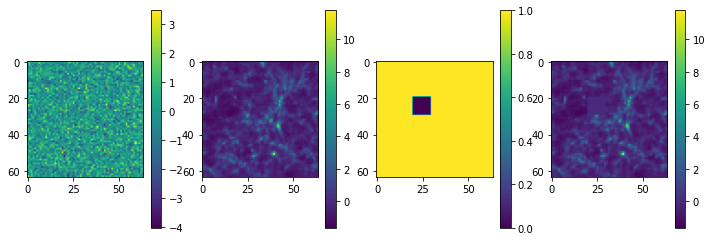

In [61]:
fig, ax = plt.subplots(1, 4, figsize = (12, 4))

im = ax[0].imshow(np.squeeze(inp))
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.squeeze(data))
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(np.squeeze(mask2))
plt.colorbar(im, ax=ax[2])
im = ax[3].imshow(np.squeeze(data*mask2))
plt.colorbar(im, ax=ax[3])

In [62]:

class UNetModel(tf.keras.Model):

    def __init__(self, n_layers = 2, n_filters = 64, kernel_size = 3):
    
        super(UNetModel, self).__init__()
        self.conv11 = Conv2D(n_filters, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal', trainable=True)
        self.conv12 = Conv2D(n_filters, kernel_size, activation='relu', padding='same',  trainable=True)
        self.pool1 = Conv2D(n_filters, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal', trainable=True, strides=2)
        self.conv21 = Conv2D(n_filters*2, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal', trainable=True)
        self.conv22 = Conv2D(n_filters*2, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal', trainable=True)
        self.pool2 = Conv2D(n_filters, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal', trainable=True, strides=2)
        self.conv31 = Conv2D(n_filters*4, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal', trainable=True)
        self.conv32 = Conv2D(n_filters*4, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal', trainable=True)
        
        self.upconv1 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding='same')
        self.conv23 = Conv2D(n_filters*2, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal', trainable=True)
        self.conv24 = Conv2D(n_filters*2, kernel_size, activation='relu', padding='same', kernel_initializer='he_normal', trainable=True)
        self.upconv2 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding='same')
        self.conv13 = Conv2D(n_filters, kernel_size, activation='relu', padding='same',  trainable=True)
        self.conv14 = Conv2D(n_filters, kernel_size, activation='relu', padding='same',  trainable=True)       

        self.convlast = Conv2D(1, kernel_size, activation=None, padding='same')
#         self.batchnorm1 = BatchNormalization()   
#         self.batchnorm2 = BatchNormalization()   
        self.concat = concatenate
        
    def call(self, inputs, training=False):

        x = self.conv11(inputs) 
        x = self.conv12(x)        

        x1 = x*1.
        x = self.pool1(x)
        
        x = self.conv21(x) 
        x = self.conv22(x)
        
        x2 = x*1.
        x = self.pool2(x)
        
        x = self.conv31(x) 
        x = self.conv32(x)
        
        x = self.upconv1(x)
#         x = self.concat([x, x2])        
        x = self.conv23(x) 
        x = self.conv24(x)
        
        x = self.upconv2(x)
#         x = self.concat([x, x1])        
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.convlast(x)
        return x
    


4134.6694
0.0006945082
1.2830852e-10
0.0013346113
3.0755032e-10


[]

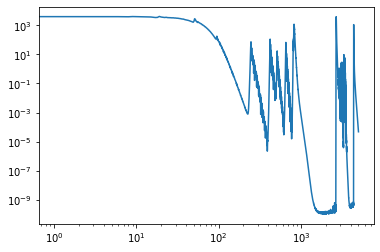

In [63]:
model = UNetModel()
model(inp); 
opt = tf.optimizers.Adam(0.001)


@tf.function
def l2_loss(y, target):
    return tf.reduce_sum( (mask2*(target-y)) **2) 
#     return tf.reduce_sum( ((target-y)) **2) 


@tf.function
def train_step(x, target):
#     print(target.numpy())
    with tf.GradientTape() as tape:
        y = model(x, training=True)
        loss = l2_loss(y, target)
#         loss = tf.reduce_sum( (1*(target-y)) **2) 
        trainable_vars = model.trainable_variables 
        # Calculate gradient          
        grads = tape.gradient(loss, trainable_vars)
        # And then apply the gradient to change the weights
        opt.apply_gradients(zip(grads, trainable_vars))
        
        

losses = []
for i in range(5000):
    train_step(tf.constant(inp), tf.constant(data))
    losses.append(l2_loss(model(tf.constant(inp)), tf.constant(data)).numpy())
    if i%1000 == 0:
        print(losses[-1])
pred = model(inp).numpy()
plt.plot(losses)
plt.loglog()

In [64]:
# model.compile(optimizer='adam', loss=tf.losses.mean_squared_error)

In [85]:
# inp2  = inp2*0 + 1
# model2 = UNetModel()
# model2(inp2); 
# opt = tf.optimizers.Adam(0.01)

# @tf.function
# def train_step(x, target, mod):
#     with tf.GradientTape() as tape:
#         y = mod(x, training=True)
#         loss = l2_loss(y, target)
#         trainable_vars = mod.trainable_variables 
#         # Calculate gradient          
#         grads = tape.gradient(loss, trainable_vars)
#         # And then apply the gradient to change the weights
#         opt.apply_gradients(zip(grads, trainable_vars))
        
        
        
# losses = []
# for i in range(10000):
#     train_step(inp2, data, model2)
#     losses.append(l2_loss(model2(inp2), data).numpy())
#     if i%1000 == 0:
#         print(losses[-1])
# pred2 = model2(inp2).numpy()
# plt.plot(losses)
# plt.loglog()

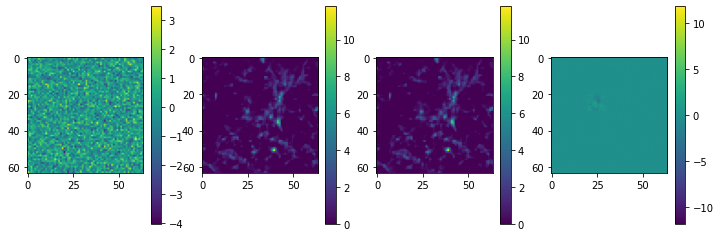

In [65]:
fig, ax = plt.subplots(1, 4, figsize = (12, 4))

vmin, vmax = data.min(), data.max()
vmin = 0 
im = ax[0].imshow(np.squeeze(inp))
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.squeeze(data), vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(np.squeeze(pred), vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[2])
im = ax[3].imshow(np.squeeze(pred - data), vmin=-vmax, vmax=vmax)
plt.colorbar(im, ax=ax[3])

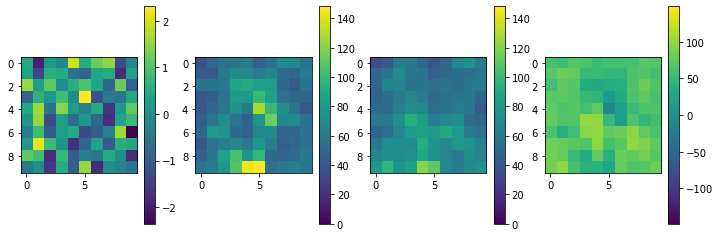

In [66]:
fig, ax = plt.subplots(1, 4, figsize = (12, 4))

vmin, vmax = np.squeeze(data*dstd + dmean)[x1:x2, y1:y2].min(), np.squeeze(data*dstd + dmean)[x1:x2, y1:y2].max()
vmin = 0 
im = ax[0].imshow(np.squeeze(inp)[x1:x2, y1:y2])
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.squeeze(data*dstd + dmean)[x1:x2, y1:y2], vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(np.squeeze(pred*dstd + dmean)[x1:x2, y1:y2], vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[2])
# im = ax[3].imshow(np.squeeze(pred - data)[x1:x2, y1:y2], vmin=-vmax, vmax=vmax)
im = ax[3].imshow(np.squeeze((pred - data)*dstd + dmean)[x1:x2, y1:y2], vmin=-vmax, vmax=vmax)
# im = ax[3].imshow(np.squeeze((pred - data)*dstd + dmean)[x1:x2, y1:y2], vmin=-vmax, vmax=vmax)
plt.colorbar(im, ax=ax[3])

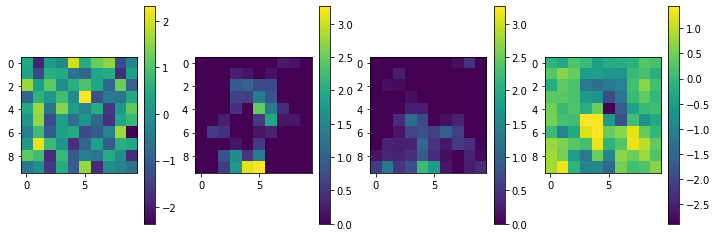

In [67]:
fig, ax = plt.subplots(1, 4, figsize = (12, 4))

vmin, vmax = data[0, x1:x2, y1:y2].min(), data[0, x1:x2, y1:y2].max()
vmin = 0 
im = ax[0].imshow(np.squeeze(inp)[x1:x2, y1:y2])
plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.squeeze(data)[x1:x2, y1:y2], vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(np.squeeze(pred)[x1:x2, y1:y2], vmin=vmin, vmax=vmax)
plt.colorbar(im, ax=ax[2])
# im = ax[3].imshow(np.squeeze(pred2 - data)[x1:x2, y1:y2], vmin=-vmax, vmax=vmax)
im = ax[3].imshow(np.squeeze(pred - data)[x1:x2, y1:y2])
plt.colorbar(im, ax=ax[3])

In [ ]:
# # @tf.function
# def unet(x, n_filters=64):
#   # Contracting Path (encoding)
# #   inputs = Input(flags_obj.input_size)
#     conv1 = Conv2D(n_filters,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(x)
#     conv1 = Conv2D(n_filters,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

#     conv2 = Conv2D(n_filters * 2,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(pool1)
#     conv2 = Conv2D(n_filters * 2,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

#     conv3 = Conv2D(n_filters * 4,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(pool2)
#     conv3 = Conv2D(n_filters * 4,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

#     conv4 = Conv2D(n_filters * 8,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(pool3)
#     conv4 = Conv2D(n_filters * 8,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(conv4)
#     drop4 = Dropout(0.3)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = Conv2D(n_filters * 16,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(pool4)
#     conv5 = Conv2D(n_filters * 16,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(conv5)
#     drop5 = Dropout(0.3)(conv5)

#     # Expansive Path (decoding)
#     up6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2),
#                         padding='same')(drop5)
#     merge6 = concatenate([up6, drop4], axis=3)
#     conv6 = Conv2D(n_filters * 8,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(merge6)
#     conv6 = Conv2D(n_filters * 8,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(conv6)

#     up7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2),
#                         padding='same')(conv6)
#     merge7 = concatenate([up7, conv3], axis=3)
#     conv7 = Conv2D(n_filters * 4,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(merge7)
#     conv7 = Conv2D(n_filters * 4,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(conv7)

#     up8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2),
#                         padding='same')(conv7)
#     merge8 = concatenate([up8, conv2], axis=3)
#     conv8 = Conv2D(n_filters * 2,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(merge8)
#     conv8 = Conv2D(n_filters * 2,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(conv8)

#     up9 = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2),
#                         padding='same')(conv8)
#     merge9 = concatenate([up9, conv1], axis=3)
#     conv9 = Conv2D(n_filters,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(merge9)
#     conv9 = Conv2D(n_filters,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(conv9)
#     conv9 = Conv2D(2,
#                  3,
#                  activation='relu',
#                  padding='same',
#                  kernel_initializer='he_normal')(conv9)

#     conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
#     return conv10
# #   model = tf.keras.Model(inputs=x, outputs=conv10)
# #   return model

# Test models

In [428]:

class MyModel(tf.keras.Model):

  def __init__(self):
    super(MyModel, self).__init__()
    self.dense1 = tf.keras.layers.Dense(4, activation=tf.nn.relu)
    self.dense2 = tf.keras.layers.Dense(5, activation=tf.nn.softmax)
    self.dropout = tf.keras.layers.Dropout(0.5)

  def call(self, inputs, training=False):
    x = self.dense1(inputs)
    if training:
      x = self.dropout(x, training=training)
    return self.dense2(x)

model = MyModel()

In [430]:
x = np.random.random((2, 3))
y = np.random.randint(0, 2, (2, 2))
model.compile()
model.fit(x, y)
model.metrics_names

ValueError: in user code:

    /mnt/home/cmodi/miniconda3/envs/defpyn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /mnt/home/cmodi/miniconda3/envs/defpyn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /mnt/home/cmodi/miniconda3/envs/defpyn/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /mnt/home/cmodi/miniconda3/envs/defpyn/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /mnt/home/cmodi/miniconda3/envs/defpyn/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /mnt/home/cmodi/miniconda3/envs/defpyn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /mnt/home/cmodi/miniconda3/envs/defpyn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:756 train_step
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
    /mnt/home/cmodi/miniconda3/envs/defpyn/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:2736 _minimize
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
    /mnt/home/cmodi/miniconda3/envs/defpyn/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:562 _aggregate_gradients
        filtered_grads_and_vars = _filter_grads(grads_and_vars)
    /mnt/home/cmodi/miniconda3/envs/defpyn/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:1270 _filter_grads
        raise ValueError("No gradients provided for any variable: %s." %

    ValueError: No gradients provided for any variable: ['my_model_1/dense_2/kernel:0', 'my_model_1/dense_2/bias:0', 'my_model_1/dense_3/kernel:0', 'my_model_1/dense_3/bias:0'].


# Copy from Colab

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [5]:

# Prepare the training dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [3]:
# inputs = keras.Input(shape=(784,), name="digits")
# x1 = layers.Dense(64, activation="relu")(inputs)
# x2 = layers.Dense(64, activation="relu")(x1)
# outputs = layers.Dense(10, name="predictions")(x2)
# model = keras.Model(inputs=inputs, outputs=outputs)

# # Instantiate an optimizer.
# optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# # Instantiate a loss function.
# loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [4]:
# # Get model

# inputs = keras.Input(shape=(784,), name="digits")
# x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
# x = layers.Dense(64, activation="relu", name="dense_2")(x)
# outputs = layers.Dense(10, name="predictions")(x)
# model = keras.Model(inputs=inputs, outputs=outputs)



In [25]:

class MyModel(tf.keras.Model):
# class MyModel(layers.Layer):

    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = layers.Dense(64, activation=tf.nn.relu)
        self.dense2 = layers.Dense(64, activation=tf.nn.relu)
        self.dense3 = layers.Dense(10, activation=None)

    def __call__(self, inputs, training=False):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x =  self.dense3(x)
        return x


model = MyModel()


# # Instantiate an optimizer to train the model.
# optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# # Instantiate a loss function.
# loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# # Prepare the metrics.
# train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
# val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [26]:
# Instantiate an optimizer to train the model.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

In [27]:
# model.compile()
# model.fit(x_train, y_train)

In [28]:


@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
#     print(model.trainable_weights)
    grads = tape.gradient(loss_value, model.trainable_weights)
#     print(grads)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value


@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)


In [29]:
import time

epochs = 10
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * 64))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 163.9958
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.5864
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.6283
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.2429
Seen so far: 38464 samples
Training acc over epoch: 0.6696
Validation acc: 0.7857
Time taken: 2.00s

Start of epoch 1
Training loss (for one batch) at step 0: 0.8684
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.5196
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 0.6670
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 0.5965
Seen so far: 38464 samples
Training acc over epoch: 0.8108
Validation acc: 0.8487
Time taken: 1.75s

Start of epoch 2
Training loss (for one batch) at step 0: 0.5481
Seen so far: 64 samples
Training loss (for one batch) at step 200: 0.7581
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 

In [6]:
model(x_train)

<tf.Tensor: shape=(50000, 10), dtype=float32, numpy=
array([[ -0.8096285 ,   1.4510715 ,  10.2902155 , ..., -12.769337  ,
          9.151145  ,  13.263184  ],
       [ 21.472101  ,  -3.3365967 ,  -7.422959  , ...,  -9.696174  ,
         -8.429608  ,  -9.064557  ],
       [ -3.85416   ,  -3.215013  ,   8.269674  , ...,   6.0891623 ,
          0.95176345,   7.062042  ],
       ...,
       [ -7.989009  ,   9.547194  ,   9.719972  , ...,   0.5028684 ,
         11.556689  ,   5.2056484 ],
       [ -1.4876635 ,  -5.5289936 ,   5.090549  , ...,   3.9083974 ,
         -0.35466182,   6.69474   ],
       [ -2.0703022 ,   8.609317  ,  10.356324  , ...,  -3.0839639 ,
         15.915162  ,   8.572757  ]], dtype=float32)>